## Import libraries, load pkl file, standardized functions

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle as pkl
import scipy.interpolate
import time
from scipy.signal import savgol_filter

In [2]:
superhist = "histdataset1.pkl"
with open(superhist, "rb") as f:
    ds = pkl.load(f)

keys = ds.keys()
print(keys)

#in making the superhistogram, I only saved the data between 26500 and 103000 (see makehist line 237) 
#making the first bin 26500 as the left edge 

countarr = ds["C10"] #strictly the compiled im_arr of all the images 
mbins = np.arange(26500, 26500+len(countarr)) #built into the dataset 

start = np.argwhere(mbins == 30000)

termcountarr = countarr[start[0][0]:] #this starts histogram at 30,000
termbins = mbins[start[0][0]:] #this is the adc codes which this is valid for

dict_keys(['C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C07', 'C06', 'C05', 'C04', 'C03', 'C02', 'C01', 'C00'])


In [3]:
print(len(termcountarr))

73000


In [4]:
def examineinl(edges, binsnum, edgemethodname): #here binsnum is binnumbers 
    idealmids = 0.5 + binsnum    
    adcmids = [sum(i) for i in zip(edges[1:], edges[:-1])] #add together elements
    adcmids[:] = [x / 2 for x in adcmids] #find their mean, verified 3 entires, sufficient
    arraymids = np.array(adcmids)*(-1) 
    inl = [sum(i) for i in zip(idealmids, arraymids)]
    plt.plot(binsnum, inl, color='black', label='inl')
    plt.title(f'{edgemethodname} inl by bin number')
    plt.xlabel("bin number")
    plt.ylabel("inl")
    plt.legend()
    plt.grid()
    return inl 

def makenarrow(bcvar, right, left):
    width = right - left
    width *= (1-bcvar) #reduce the lenght of the bin 
    right = width + left 
    bcvar *= 0.85 #make the change amount reduced by 85% 
    return right, bcvar
    
def makewide(bcvar, right, left): #function increases the bin width 
    width = right - left
    width *= (1+bcvar)
    right = width + left 
    bcvar *= 0.85 
    return right, bcvar

def buildedges(cs, counts): #reduces
    edges = [30000] #define the first edge to be 30k 
    for a in range(len(counts)): 
        left = edges[-1]
        if left > 103000: #prevent interpolation beyond what we have for values
            break
        inte = cs.integrate(left, left+1) #generically make the width = 1        
        right = left + 1 
        x = 0 #a counter for issues 
        bcvar = 0.25 #bin change variable (start with 25% change)
        while len(edges) != a+2: 
            if counts[a]-0.01 < inte < counts[a] +0.01: #make the requirement sufficient
                edges.append(right)  
            elif counts[a] > inte: #bin is too small, widen right edge
                right, bcvar = makewide(bcvar, right, left)
                inte = cs.integrate(left, right)       
            elif counts[a] < inte:  #bin is too big
                right, bcvar = makenarrow(bcvar, right, left)
                inte = cs.integrate(left, right)
            x +=1 
    return edges

just start with doing Steve's suggestion 

## Method 1
cubic spline function onto the savgol filtered datapoints
using bins +0.5 such that values are in the center of a bin, not the left edge

In [5]:
smoothed = savgol_filter(termcountarr, 33, 3)
cs1 = scipy.interpolate.CubicSpline(termbins +0.5, smoothed) #spline fitting for the smoothed values
csx = np.arange(30000, 30000+len(termbins), 0.1)

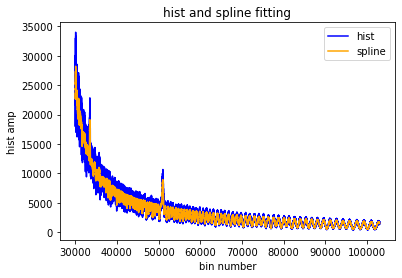

In [6]:
plt.plot(termbins, termcountarr, label="hist", color='blue')
plt.plot(csx, cs1(csx), label="spline", color='orange')
plt.title("hist and spline fitting")
plt.xlabel("bin number")
plt.ylabel("hist amp")
plt.legend()

In [7]:
edges1 = buildedges(cs1, termcountarr)

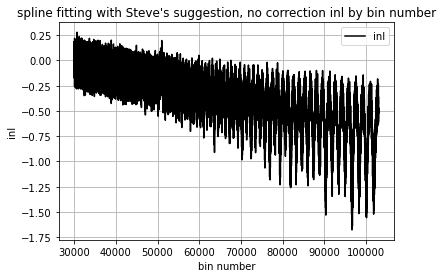

In [8]:
bins1 = 30000 + np.arange(0, len(edges1)-1)
inl1 = examineinl(edges1, bins1, "spline fitting with Steve's suggestion, no correction")

In [9]:
print("the largest inl is,", min(inl1))

the largest inl is, -1.6782198327127844


next look at the cumulative sum and the integral over the entire region 

In [10]:
## check the totals
splineint = cs1.integrate(termbins[0], termbins[-1]) 
print("the spline integral", splineint)

total = sum(termcountarr[:-1]) #add every element in the list, except the last one 
print("the hist sum is", total)

totalsavgol = sum(smoothed[:-1])
print("the savgol sum is:", totalsavgol)
print("")

print('spline - sumhist:', splineint-total)
print("savgol - sumhist:", totalsavgol-total)
print("savgol - spline", totalsavgol - splineint)
print("")

the spline integral 272858720.8060322
the hist sum is 272859461
the savgol sum is: 272858709.2578698

spline - sumhist: -740.1939678192139
savgol - sumhist: -751.7421302199364
savgol - spline -11.548162400722504



## Method 1.2: Add a correction
there is a mismatch of the integral and the cumulative sum, try correcting for this by correcting the smoothed output before you make the spline

In [11]:
smoothed2 = savgol_filter(termcountarr, 33, 3)

#add a correction term to account for the mismatch between the outputs
corr = sum(termcountarr)/sum(smoothed2)
smoothed2 *= corr 

cs2 = scipy.interpolate.CubicSpline(termbins +0.5, smoothed2) #spline fitting for the smoothed values

In [12]:
print(termbins+0.5)

[ 30000.5  30001.5  30002.5 ... 102997.5 102998.5 102999.5]


In [13]:
edges2 = buildedges(cs2, termcountarr)

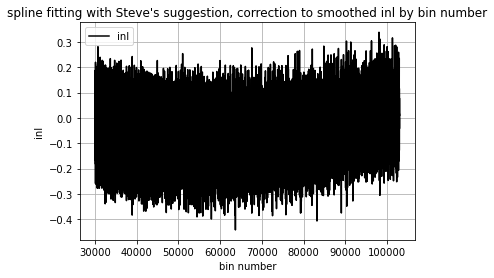

In [14]:
bins2 = 30000 + np.arange(0, len(edges2)-1)
inl2 = examineinl(edges2, bins2, "spline fitting with Steve's suggestion, correction to smoothed")

In [15]:
print("the largest (negative) inl is,", min(inl2))
print("the largest (positive) inl is,", max(inl2))

the largest (negative) inl is, -0.44269298658764455
the largest (positive) inl is, 0.3388031099893851


In [16]:
## check the totals

splineint = cs2.integrate(termbins[0], termbins[-1]) 
print("the spline integral", splineint)

total = sum(termcountarr[:-1]) #add every element in the list, except the last one 
print("the hist sum is", total)

totalsavgol = sum(smoothed2[:-1])
print("the savgol sum is:", totalsavgol)
print("")

print('spline - sumhist:', splineint-total)
print("savgol - sumhist:", totalsavgol-total)
print("savgol - spline", totalsavgol - splineint)
print()
print("")

the spline integral 272859467.58696216
the hist sum is 272859461
the savgol sum is: 272859456.0387651

spline - sumhist: 6.586962163448334
savgol - sumhist: -4.961234927177429
savgol - spline -11.548197090625763




with a correction the values are not too far off

## Method 2: Issue of interpolation of the spline
The spline function as written above fits data points between 30,000.5 and 129,999.5, outside this region the interpolation is known to be not represent the behavior overall. Since in the build edges we start making the edges at 30k, half a bin would use the interpolation. Since we added a (arbitrary) cutoff of bins below 30k, here I add back in bin 29,999.5 such that the spline is defined at 30k and our binning method can continue. Note another method around this would be to start binning at 30,001 instead. 

In [17]:
start2 = np.argwhere(mbins == 29999)

termcountarr2 = countarr[start2[0][0]:] #this starts histogram at 30,000
termbins2 = mbins[start2[0][0]:] #this is the adc codes which this is valid for

In [18]:
smoothed6 = savgol_filter(termcountarr2, 33, 3)
cs6 = scipy.interpolate.CubicSpline(termbins2 +0.5, smoothed6) #spline fitting for the smoothed values

In [19]:
edges6 = buildedges(cs6, termcountarr) #do not make a bin for 29,999 use original hist array 30-103k 

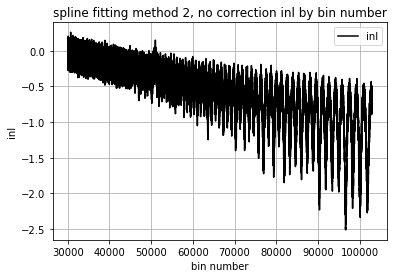

In [20]:
bins6 = 30000 + np.arange(0, len(edges6)-1)
inl6 = examineinl(edges6, bins6, "spline fitting method 2, no correction")

## Method 2.1
the above method with the correction to the smoothed 

In [21]:
smoothed7 = savgol_filter(termcountarr2, 33, 3)

#add a correction term to account for the mismatch between the outputs
corr = sum(termcountarr2)/sum(smoothed7)
smoothed7 *= corr 

cs7 = scipy.interpolate.CubicSpline(termbins2 +0.5, smoothed7) #spline fitting for the smoothed values

In [22]:
edges7 = buildedges(cs7, termcountarr)

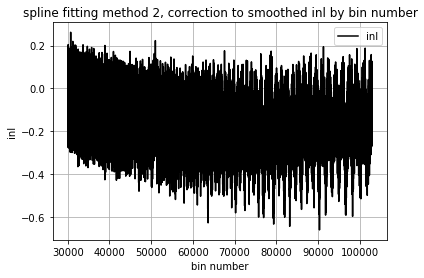

In [23]:
bins7 = 30000 + np.arange(0, len(edges7)-1)
inl7 = examineinl(edges7, bins7, "spline fitting method 2, correction to smoothed")